### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Imports

In [2]:
import numpy as np
import pandas as pd
import mediapipe as mp
import scipy.io as sio
import cv2
import os
import glob
import random
from pathlib import Path
from math import sin, cos
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

# **Preparation and Preprocessing**

In [4]:
mp_faceModule = mp.solutions.face_mesh
face_mesh = mp_faceModule.FaceMesh(static_image_mode=True)

mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [5]:
def createRecord(image, mat_file=None):
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    records = []
    if results.multi_face_landmarks != None: 

        for face in results.multi_face_landmarks:
            record = {}

            # Nose landmark, to be used as an origin for the rest of points
            center_x = face.landmark[99].x * image.shape[1]
            center_y = face.landmark[99].y * image.shape[0]

            # Forehead midpoint landmark
            x_10 = face.landmark[10].x * image.shape[1]
            y_10 = face.landmark[10].y * image.shape[0]

            # Distance between points, to be used for normalization
            distance = np.linalg.norm(np.array((x_10, y_10)) - np.array((center_x, center_y)))

            # Extracting the 468 landmark points
            for i, landmark in enumerate(face.landmark):
                record['x_' + str(i+1)] = (landmark.x * image.shape[1] - center_x) / distance
                record['y_' + str(i+1)] = (landmark.y * image.shape[0] - center_y) / distance

            # Extracting pitch, yaw and roll
            if mat_file:
                pose_para = mat_file["Pose_Para"][0][:3]
                record['pitch'] = pose_para[0]
                record['yaw'] = pose_para[1]
                record['roll'] = pose_para[2]

            records.append(record)
    
    return records
            

In [6]:
def prepareTrainData(path):
    data = []
    for filename in glob.glob(path + '/*.jpg'):
        image = cv2.imread(filename)
        mat_file = sio.loadmat(filename.replace('.jpg', '.mat'))
        data.extend(createRecord(image, mat_file))
    return pd.DataFrame(data)                

In [7]:
path = '/content/AFLW2000'
train_data = prepareTrainData(path)

In [8]:
train_data.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,y_465,x_466,y_466,x_467,y_467,x_468,y_468,pitch,yaw,roll
0,0.119520,0.149508,0.208776,-0.098079,0.076985,-0.007612,0.050341,-0.299332,0.212264,-0.167746,...,-0.478869,-0.031390,-0.462377,0.076248,-0.566283,0.076396,-0.589659,0.225152,-0.858014,-0.263081
1,0.083253,0.143124,0.090671,-0.003179,0.088291,0.027734,0.046661,-0.233036,0.093269,-0.063366,...,-0.427275,0.209684,-0.408691,0.561020,-0.482270,0.589834,-0.499225,-0.331075,0.014285,0.067926
2,0.060911,0.140014,0.093144,-0.023793,0.073332,0.021429,0.053287,-0.246036,0.099686,-0.087338,...,-0.408189,0.182831,-0.395336,0.490993,-0.464332,0.515826,-0.471915,-0.252363,-0.085357,0.042692
3,0.016950,0.147833,0.239996,0.005067,0.070523,0.032499,0.188289,-0.242617,0.271717,-0.061034,...,-0.435090,0.154737,-0.411538,0.239207,-0.454673,0.251621,-0.474896,-0.324275,-1.004428,0.431792
4,0.103717,0.141208,0.221925,-0.094052,0.074674,-0.002724,0.077184,-0.287973,0.231055,-0.161024,...,-0.454708,0.003974,-0.439139,0.109283,-0.502323,0.114854,-0.534710,0.138026,-0.754013,-0.034957


In [9]:
X = train_data.iloc[:, :-3]
y = train_data.iloc[:, -3:]

In [10]:
X.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467,x_468,y_468
0,0.119520,0.149508,0.208776,-0.098079,0.076985,-0.007612,0.050341,-0.299332,0.212264,-0.167746,...,-0.055921,-0.504323,-0.054138,-0.478869,-0.031390,-0.462377,0.076248,-0.566283,0.076396,-0.589659
1,0.083253,0.143124,0.090671,-0.003179,0.088291,0.027734,0.046661,-0.233036,0.093269,-0.063366,...,0.259705,-0.446330,0.227230,-0.427275,0.209684,-0.408691,0.561020,-0.482270,0.589834,-0.499225
2,0.060911,0.140014,0.093144,-0.023793,0.073332,0.021429,0.053287,-0.246036,0.099686,-0.087338,...,0.227736,-0.423073,0.196921,-0.408189,0.182831,-0.395336,0.490993,-0.464332,0.515826,-0.471915
3,0.016950,0.147833,0.239996,0.005067,0.070523,0.032499,0.188289,-0.242617,0.271717,-0.061034,...,0.136769,-0.457888,0.135178,-0.435090,0.154737,-0.411538,0.239207,-0.454673,0.251621,-0.474896
4,0.103717,0.141208,0.221925,-0.094052,0.074674,-0.002724,0.077184,-0.287973,0.231055,-0.161024,...,-0.015627,-0.477289,-0.017813,-0.454708,0.003974,-0.439139,0.109283,-0.502323,0.114854,-0.534710


In [11]:
y.head()

,pitch,yaw,roll
0,0.225152,-0.858014,-0.263081
1,-0.331075,0.014285,0.067926
2,-0.252363,-0.085357,0.042692
3,-0.324275,-1.004428,0.431792
4,0.138026,-0.754013,-0.034957


# **Visualization**

In [12]:
def draw_axis(img, pitch, yaw, roll, size = 100):

    yaw = -yaw

    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Setting one of the nose's points (4, 5, 6, 99) as the origin point
    tdx = int(results.multi_face_landmarks[0].landmark[99].x * img.shape[1])
    tdy = int(results.multi_face_landmarks[0].landmark[99].y * img.shape[0])

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

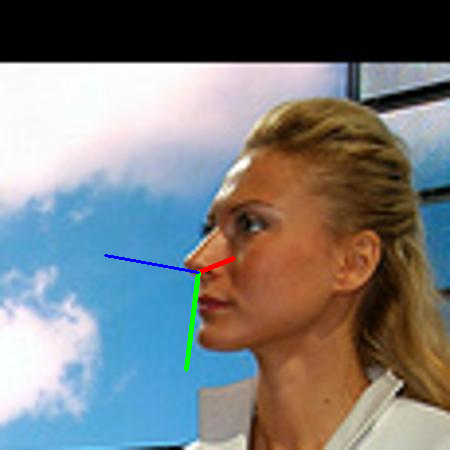

In [14]:
random_file = 'image00004'
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image, pitch, yaw, roll))

# **Model Training**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=256)

## Multi-Output Regressor with SVR

In [16]:
svr_model = MultiOutputRegressor(SVR(kernel='rbf'))
svr_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [17]:
preds = svr_model.predict(X_test)
r2_score(y_test, preds)

0.8489385868802938

# **Testing on video**

In [18]:
from google.colab import files
uploaded = files.upload()

Saving Mr_Bean_(test_input).mp4 to Mr_Bean_(test_input).mp4


In [19]:
cap = cv2.VideoCapture('Mr_Bean_(test_input).mp4')

frames = []
while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    height, width, layers = frame.shape
    size = (width, height)
    features = pd.DataFrame(createRecord(frame))
    if features.empty:
        continue
    labels = svr_model.predict(features)
    out_frame = draw_axis(frame, labels[0][0], labels[0][1], labels[0][2])
    frames.append(out_frame)

In [20]:
video_name = 'Mr_Bean_(test_output).mp4'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for frame in frames:
    video.write(frame)




video.release()
cap.release()
cv2.destroyAllWindows()